In [10]:
import cv2
import yaml
import itertools

import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split

from yolov2.utils.painter import draw_boxes
from yolov2.utils.parser import parse_inputs, parse_label_map

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
training_path ='../pascal/training_data.csv'
config_file   = 'config.yml'

In [12]:
with open(config_file, 'r') as stream:
    config = yaml.load(stream)
    
anchors = config['anchors']
label_dict = parse_label_map(config['label_map'])
inv_map = {v: k for k, v in label_dict.iteritems()}
inputs, labels = parse_inputs(training_path, inv_map)


# Create 10-fold split
x_train, x_val = train_test_split(inputs, test_size=0.2)
y_train = [labels[k] for k in x_train]
y_val   = [labels[k] for k in x_val]

print("Number of training samples: {} || {}".format(len(x_train), len(y_train)))
print("Number of validation samples: {} || {}".format(len(x_val), len(y_val)))

Number of training samples: 12064 || 12064
Number of validation samples: 3016 || 3016


In [78]:
import numpy as np

num_anchors = config['model']['num_anchors']
num_classes = 20
shrink_factor = config['model']['shrink_factor']


def data_generator(images, labels, img_size, shuffle=True, batch_size=4):
    dataset   = create_tfdata(images, labels, img_size, shuffle, batch_size)
    iterator   = dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()
    while True:
        yield K.get_session().run(next_batch)

def create_tfdata(images, labels, img_size, shuffle=True, batch_size=4):
    
    def read_img_file(filename, label):
        image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        image  = cv2.resize(image, (img_size, img_size))
        
        # A label is consist of [y1, x1, y1, x1, class_idx]
        label  = np.reshape(label, (-1, 5))
   
        # Convert coordinates to relative values
        boxes  = label[..., 0:4] / np.array([height, width , height , width], np.float32)
        
        # Adjust boxes to correct ratio (due to distorted image)
        w_ratio = width / float(height)  if width < height else 1.0
        h_ratio = height / float(width)  if width < height else 1.0 
        boxes   = boxes * np.array([h_ratio, w_ratio, h_ratio, w_ratio], np.float32)
        
        label  = np.concatenate([boxes, np.expand_dims(label[...,-1],1)], axis=-1)
        return image, label

    def process_label(img, label):
        
        # Generate feature map using scater_nd
        boxes, classes = tf.split(label, [4, 1], 1)
        
        # 1. Determine indices (where to put gtruths in the feature map)
        area     = boxes[...,2:4] - boxes[..., 0:2]
        centroid = boxes[..., 0:2] + (area / 2.0)    
        indices  = tf.cast(tf.floor(centroid * (img_size / shrink_factor)), tf.int32)
        
        # 2. Construct output feature
        objectness = tf.ones_like(classes)
        one_hot    = tf.one_hot(tf.cast(tf.squeeze(classes, axis=1), tf.uint8), num_classes)
        values     = tf.concat([boxes, objectness, classes], axis=-1)
        
        # 3. Create feature map
        # https://www.tensorflow.org/api_docs/python/tf/scatter_nd
#         shape  = tf.constant([img_size/shrink_factor, img_size/shrink_factor, 5])   
#         output = tf.scatter_nd(indices=indices, updates=values, shape=shape)
        return img, values

    # a hack to handle list with different element size.
    dataset = tf.data.Dataset.from_generator(lambda: itertools.izip_longest(images, labels),
                                             (tf.string, tf.float32),
                                             (tf.TensorShape([]), tf.TensorShape([None])))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
        
    dataset = dataset.map(lambda filename, label:
                          tuple(tf.py_func(read_img_file,
                                           [filename, label],
                                           [tf.uint8, label.dtype])))
    dataset = dataset.map(process_label)
    dataset = dataset.padded_batch(batch_size, 
                                   padded_shapes=([None, None, 3], 
                                                  [None, None]))
    return dataset
    
val_gen = data_generator(x_val,  y_val,config['model']['image_size'], batch_size=8)

In [79]:
images, labels = val_gen.next()

idx   = 0 
image = images[idx]
h,w, _ = image.shape
gt_boxes   = labels[idx][..., 0:4]
gt_classes = labels[idx][...,-1]

In [80]:
print(gt_classes)
print(gt_boxes)

[ 56.  60.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
[[ 0.36533332  0.35600001  0.736       0.46000001]
 [ 0.45066667  0.248       0.97066665  0.61400002]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


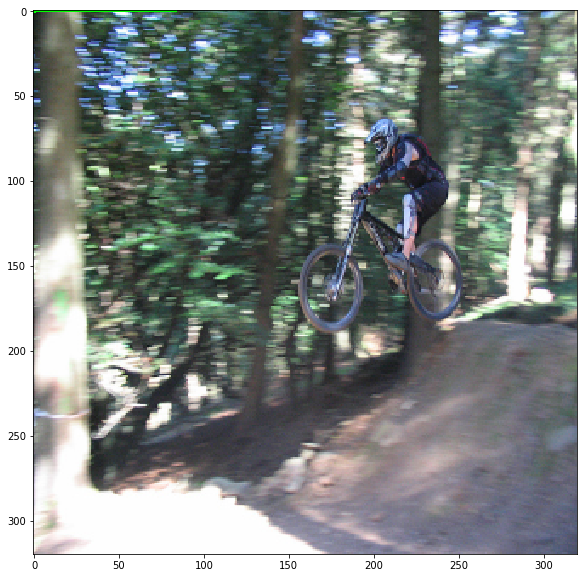

In [67]:
gt_boxes = gt_boxes * np.array([h, w, h, w]) 
plt.figure(figsize=(10, 10))

_ = plt.imshow(draw_boxes(image, 
                          gt_boxes, 
                          [label_dict[i] for i in gt_classes], gt_classes))

In [ ]:
with tf.Session() as sess:
    c =  tf.scatter_nd(tf.cast([[0, 0]], tf.int32), tf.cast([[1.0, 1.0]], tf.float32), shape=[3, 4, 2])

    tf.global_variables_initializer().run()
    print(c.eval())

In [ ]:
bboxes = np.expand_dims(gt_boxes, 0)
print bboxes

a = np.squeeze(bboxes, 0)
print a